In [1]:
# Setup (PyTorch, paths, device, seeds)
%load_ext autoreload
%autoreload 2

from xray_helpers import (
    seed_all, compute_pos_weight, PneumoCNN,
    eval_one_epoch, fit,
    pick_threshold_from_val, evaluate_with_threshold, show_split_counts, balance_val_train_split, plot_curves
)

import os
import kagglehub
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
seed_all(42)

In [3]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# Use the returned path to set base_dir correctly
base_dir = os.path.join(path, "chest_xray")
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

In [4]:
print("Train dir:", train_dir)
print("Train dir contents:", os.listdir(train_dir))
print("Val dir:", val_dir)
print("Val dir contents:", os.listdir(val_dir))
print("Test dir:", test_dir)
print("Test dir contents:", os.listdir(test_dir))

Train dir: /Users/daniel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train
Train dir contents: ['.DS_Store', 'PNEUMONIA', 'NORMAL']
Val dir: /Users/daniel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val
Val dir contents: ['.DS_Store', 'PNEUMONIA', 'NORMAL']
Test dir: /Users/daniel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test
Test dir contents: ['.DS_Store', 'PNEUMONIA', 'NORMAL']


Before split:
train/NORMAL: 1341
train/PNEUMONIA: 3875
val/NORMAL: 8
val/PNEUMONIA: 8


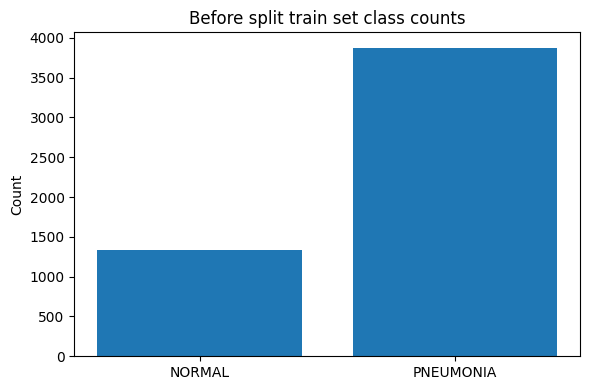

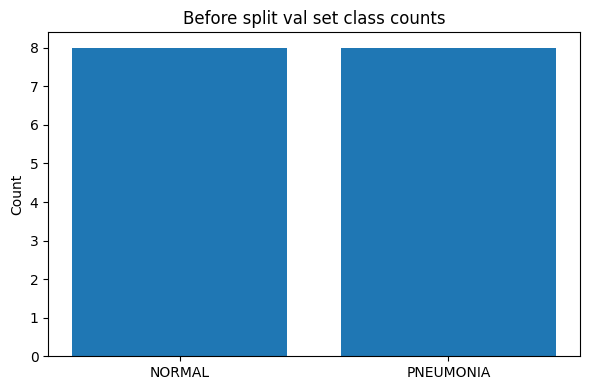

After split:
train/NORMAL: 1341
train/PNEUMONIA: 3875
val/NORMAL: 8
val/PNEUMONIA: 8


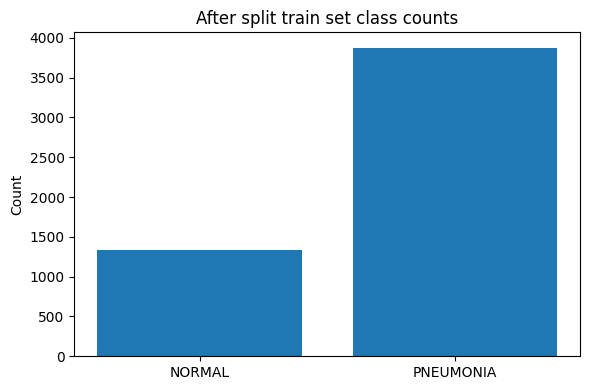

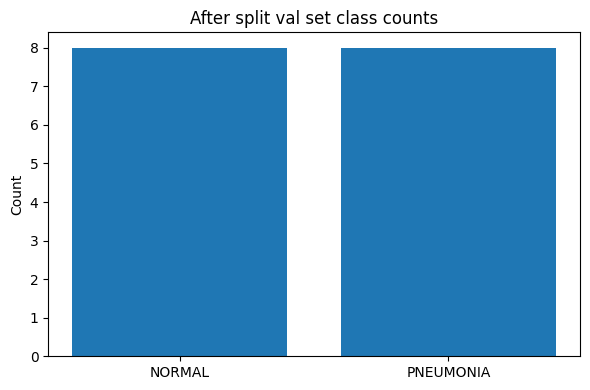

In [5]:
# Plot distribution of classes in train, val, and test sets
class_names = ['NORMAL', 'PNEUMONIA']
show_split_counts(base_dir, "Before split")
new_base = balance_val_train_split(base_dir)
show_split_counts(base_dir, "After split")

# Update directory variables to point to the new split
train_dir = os.path.join(new_base, 'train')
val_dir   = os.path.join(new_base, 'val')
# test_dir remains unchanged

In [6]:
# Datasets, DataLoaders, class weights (for imbalance)
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 4

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225])

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize,
])

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    normalize,
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tfms)

print("Classes:", train_ds.classes, "=>", train_ds.class_to_idx)

Classes: ['NORMAL', 'PNEUMONIA'] => {'NORMAL': 0, 'PNEUMONIA': 1}


In [8]:
model = PneumoCNN()
model

PneumoCNN(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)
model = model.to(device)
EPOCHS = 15
patience = int(EPOCHS * 2/3)
lr = 1e-3

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

device:  cpu


In [10]:
# Compute class weights for BCEWithLogitsLoss (pos_weight = N_neg / N_pos for label=1 class)
# In ImageFolder, NORMAL -> 0, PNEUMONIA -> 1 (alphabetical)
pos_weight = compute_pos_weight(train_ds)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

Train counts -> NEG(NORMAL)=1147, POS(PNEUMONIA)=3300, pos_weight=0.348


In [11]:
history, best_val_auc = fit(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=EPOCHS, patience=patience)

plot_curves(history)

[Train] Epoch 1/15:   0%|          | 0/70 [00:00<?, ?it/s]/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/ml/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/ml/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
[Train] Epoch 1/15:   0%|          | 0/70 [00:06<?, ?it/s]    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/__init__.py", line 10, in <module>

    from torchvision import _meta_registrations, datasets, io, models, ops, transforms, utils  # usort

KeyboardInterrupt: 

In [ ]:
_, _, va_auc, va_probs, va_targets = eval_one_epoch(model, val_loader, epochNumber=0, criterion=criterion)
best_thr = pick_threshold_from_val(va_targets, va_probs)
print("Chosen threshold:", best_thr)

In [ ]:
evaluate_with_threshold(model, test_loader, criterion, threshold=best_thr)